# Latelight Study

A modular version of MicroBooNE scintillation latelight study code for iterating through large quantity of files.

In [1]:
# General Imports

from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import uproot3
import pandas

from matplotlib.colors import LogNorm
import scipy.signal
from numpy.fft import fft, ifft, ifftshift
from matplotlib.colors import LogNorm
from scipy import optimize

In [2]:
# Plotting style file

plt.style.use("LateLightStyle.mplstyle")

## SPE Selection & Kernel Building

In [169]:
#PATH = 'data/late_light/'
#FNAME = 'prod_extbnb_optfilter_mcc9.0_reco2_lite_C2'
PATH = 'data/late_light_timedep/'
FNAME = 'prod_extunbiased_swizzle_inclusive_v3_goodruns_mcc9_run1_high_lifetime'
wffile = uproot3.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]

In [171]:
# Inspect and generate the relevant keys for identifying the PMTs

print(wffile.keys())

wffile_keys = wffile.keys()

print(wffile_keys[7])

wffile_keys = wffile_keys[7:-1]

#Concatnate this for now
#wffile_keys = wffile_keys[18:23]
print(wffile_keys)

[b'run', b'subrun', b'event', b'ped_mean_v', b'ped_rms_v', b'max_adc_v', b'min_adc_v', b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31', b'wfsum']
b'wf_00'
[b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31']


In [172]:
# Function for calculating the baseline and rms
# TODO: Consider vectorizing all these functions

def baseline(data, init):
    baseline = np.mean(data[0:init])
    #rms = np.sqrt(np.sum([(i-baseline)**2 for i in data])/len(data))
    # Vectorized version
    rms = np.sqrt(np.sum(data-baseline)**2/len(data))
    return baseline, rms

# Reparse SPE events with new parameter

def SPE_tail(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    i = 0
    while i < len(data[init:]):
        cache = []
        if 30>data[i]-baseline>10:
            if len(data[i-20:i-1])!=0 and abs(rms)<=5 and -rms<np.max([j-baseline for j in data[i-10:i-1]])<rms:
                cache.extend(data[i-10:i-1])
                while data[i]-baseline>10 and i in range(len(data[init:])):
                    cache.append(data[i])
                    i += 1
                # end of the waveform here is defined as i+4 by observation
                if max(data[i+4:i+4+after]-baseline) <= 4*rms and len(data[i+4:i+4+after])==after:
                    cache.extend(data[i+1:i+4+after])
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0 and max(cache)-baseline<30:
            waveform.append(cache-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
        else:
            pass
        i += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

# Simple function for taking average of every time bin

# for a completely rectangular data array
'''
def mean_fit(data_arr):
    mean_wf = []
    for i in range(len(data_arr[0])):
        data_pts = [j for j in data_arr[:][i]]
        mean_wf.append(np.mean(data_pts))
    return mean_wf
'''

# Given the non-uniformity of the current waveforms, we have the following avg function: 
def mean_fit(data_arr):
    mean_wf = []
    i = 0
    while True:
        try:
            # Think of a way to take the average of less and less waveforms
            mean_wf.append(np.mean([data_arr[j][i] for j in range(len(data_arr))]))
        # Try to find the specific error instead of having only except
        except:
            break
        i += 1
    return mean_wf

In [173]:
# Non-modular functions (for organization only)

# Produce a set of roughly selected SPEs
def produceSPE():
    spetail_arr = np.empty(6, dtype=object)

    for i in range(len(wfdf[0:evtn])):
        spe_temp = [SPE_tail(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time, 200)]
        if spe_temp[0] != "N":
            for j in range(len(spe_temp)):
                for l in range(len(spe_temp[j][0])):
                    spetail_arr = np.vstack((spetail_arr, np.asarray([spe_temp[j][k][l] for k in range(len(spe_temp[j]))])))
        else:
            pass

    spetail_arr = spetail_arr[1:]
    return spetail_arr

# Exclude waveforms with outlier prepulse
def SPEprepulseCut():
    spetail_mod = []

    #for i in SPEtail_selected:
    for i in SPEtail_arr:
        if max(i[0][:7])<=2.5:
            bslin_temp = np.mean(i[0][:7])
            spetail_mod.append(i[0]-bslin_temp)
        else:
            pass
    return spetail_mod

# Exclude waveforms with nonlinear amplitude-area relationship
def SPEfitCut():
    # Create a linear fit for Amplitude vs Area
    SPEtail_mod_area = [sum(i[0:25]) for i in SPEtail_mod]
    SPEtail_mod_amp = [max(i[0:25]) for i in SPEtail_mod]
    # Manually exclude clear outliers before fitting
    SPEtail_mod_amp = [SPEtail_mod_amp[i] for i in range(len(SPEtail_mod_amp)) if 0<SPEtail_mod_area[i]<190]
    SPEtail_mod_area = [i for i in SPEtail_mod_area if 0<i<190]
    # Generate the fit function
    amplinfit = np.poly1d(np.polyfit(SPEtail_mod_area,SPEtail_mod_amp,1))
    # Exlude outlier waveforms based on the amplitude vs area fit
    spetail_modfit = []
    for i in range(len(SPEtail_mod_amp)):
        if abs(SPEtail_mod_amp[i]-amplinfit(SPEtail_mod_area[i])) < 3:
            spetail_modfit.append(SPEtail_mod[i])
        else:
            pass
    return spetail_modfit

# Exclude waveforms with outlier afterpulse
def SPEafterpulseCut():
    aftersum = [sum(i[30:]) for i in SPEtail_modfit]
    afteravg = np.mean(aftersum)
    afterrms = np.std(aftersum)

    spe_clean = []

    # Right now the SPE selection seems to be largely dominated by this step with an aribitrary value upper limit
    for i in range(len(SPEtail_modfit)):
        #if afteravg-afterrms < aftersum[i] < afteravg+afterrms and max(abs(SPEtail_modfit[i][20:]))<8:
        if afteravg-afterrms < aftersum[i] < afteravg+afterrms and max(SPEtail_modfit[i][20:])<2.5:
            spe_clean.append(SPEtail_modfit[i])
        else:
            pass

    spe_clean = np.array(spe_clean)
    return spe_clean

In [174]:
# Modular functions for generating kernel

def fnoise(waveform, kernel):
    fwf = fft(waveform)
    fkn = fft(kernel)
    return (fkn*np.conj(fkn))/(fwf*np.conj(fwf)-fkn*np.conj(fkn))

In [175]:
# Non-modular functions (for organization only)

# Generating aligned function
def genKernel():
    EXPkarr_og = np.zeros(shape=(200,), dtype=object)

    for i in range(len(SPE_clean)):
        # the normalization constant could be subject to change, check PMTViewer.py
        norm_cst = 1
        # Enter the peak aligned waveforms into the kernel
        # If there are two maximum values, take the earlier one
        n = np.where(SPE_clean[i] == max(SPE_clean[i]))[0][0]
        for j in range(len(EXPkarr_og)):
            EXPkarr_og[j] = np.append(EXPkarr_og[j], SPE_clean[i][n-8+j]/norm_cst)
        EXPkarr_og_wf = [np.mean(i[1:]) for i in EXPkarr_og]
    return EXPkarr_og, EXPkarr_og_wf

# Generate SNR(f)
def genSNR():
    kernel_ft = fft(kaligned)
    # Take the average of the power spectrums of kernel+noise
    specsum = np.zeros(len(expkarr_og), dtype="complex")
    for i in range(len(expkarr_og[0])-1):
        fft_cache = fft([expkarr_og[j][i] for j in range(len(expkarr_og))])
        specsum += fft_cache*np.conj(fft_cache)
        #specsum += (fft_cache-mft)*np.conj(fft_cache-mft)
    specavg = specsum/(len(expkarr_og[0])-1)
    return (kernel_ft*np.conj(kernel_ft))/(specavg)

In [176]:
#  ++++--------------- Main -----------------++++

# INITIAL VARIABLES
# Index number of the last event included
evtn = -1
# Directory for the output
outpath = "data/run1_output/kernel/"

# Use the first 100 data points as baseline
init_time = 100

for wfkey in wffile_keys:
    wfdf = wffile.array(wfkey)
    # Calculate baseline and RMS for each evt separately
    baseline_li = []
    for i in wfdf[0:evtn]:
        baseline_li.append(baseline(i,init_time))
    baseline_arr = np.asarray(baseline_li)
    SPEtail_arr = produceSPE()
    SPEtail_mod = SPEprepulseCut()
    SPEtail_modfit = SPEfitCut()
    SPE_clean = SPEafterpulseCut()
    # Save SPE as txt files if needed
    #np.savetxt(outpath+"run3"+wfkey.decode("utf-8")+"SPE.txt", SPE_clean, fmt='%s')
    # Generate kernel
    expkarr_og, kaligned = genKernel()
    specnoise = genSNR()
    # Save SPE kernel and SNR(f)
    np.savetxt(outpath+"run1"+wfkey.decode("utf-8")+"Kernel.txt", kaligned, fmt='%s')
    np.savetxt(outpath+"run1"+wfkey.decode("utf-8")+"SNR.txt", specnoise, fmt='%s')

F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<ipython-input-173-e24887ef7698>:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spe_clean = np.array(spe_clean)


In [ ]:
print(expkarr)

In [47]:
# Temporary kernel building lines, migrate this into the Main loop once the existing data is processed
# IMPORTANT: Parsing bad SPE files might be more hassle than needed

'''
SPE_files = glob("F:/Physics/David_Caratelli_Lab/data/run1_wf/*.txt", recursive=True)

for SPE_file in SPE_files:
    SPE_clean = np.loadtxt(SPE_file, dtype=float)
    print(len(SPE_clean))
    break
'''

'\nSPE_files = glob("F:/Physics/David_Caratelli_Lab/data/run1_wf/*.txt", recursive=True)\n\nfor SPE_file in SPE_files:\n    SPE_clean = np.loadtxt(SPE_file, dtype=float)\n    print(len(SPE_clean))\n    break\n'

## Muon Selection

In [3]:
PATH = 'data/late_light_timedep/'
FNAME = 'prod_extbnb_optfilter_mcc9.0_reco2_lite_C1'
wffile = uproot3.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]

In [4]:
# Inspect and generate the relevant keys for identifying the PMTs

print(wffile.keys())

wffile_keys = wffile.keys()

#print(wffile_keys[7])

wffile_keys = wffile_keys[7:-1]

#Concatnate this for now
#wffile_keys = wffile_keys[18:]
print(wffile_keys)

[b'run', b'subrun', b'event', b'ped_mean_v', b'ped_rms_v', b'max_adc_v', b'min_adc_v', b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31', b'wfsum']
[b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31']


In [179]:
# Using similar methods as detecting SPE for detecting muons
# Assume 1 PE = 20 ADU

# Some global variables for checking different cuts
'''
maxprepul = []
maxafterpul = []
maxpeak = []
peaktime = []
arvtime = []
'''

def muon(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    # Skip the initial ticks
    k = init
    while k < len(data)-1:
        cache = []
        #if 2000>data[k]-baseline>100:
        # Modify the lower limit to take out smaller magnitude waveforms
        if 1900>data[k]-baseline>300:
            '''
            if len(data[k-20:k-1])!=0 and abs(rms) <= 150:
                maxprepul.append(np.max([j-baseline for j in data[k-20:k-1]]))
            else:
                pass
            '''
            if len(data[k-20:k-1])!=0 and -rms<np.max([j-baseline for j in data[k-20:k-1]])<rms and abs(rms)<=400:
                cache.extend(data[k-20:k-1])
                #while 2000>data[k]-baseline>100 and i in range(len(data[init:])):
                # Modify the lower limit to take out smaller magnitude waveforms
                while 1900>data[k]-baseline>300 and k in range(len(data)-1):
                    cache.append(data[k])
                    k += 1
                # Changed the estimated afterpulse length
                # This might be excessive
                cache.extend(data[k+1:k+20])
                # Move the tick
                k += 19
            # end of the waveform here is defined as i+20 by observation
                # Record the amplitude of the main pulse and the amplitude of the afterpulse
                '''
                if len(data[k+1:k+1+after])==after:
                    maxpeak.append(np.max(cache)-baseline)
                    maxafterpul.append(np.max(data[k+1:k+1+after])-baseline)
                else:
                    pass
                '''
                # TODO: double check the afterpulse selection conditions, it might be too long
                #if np.max(data[i+20:i+20+after]-baseline) <= 10*rms and np.max(data[i:i+20]-baseline) < 2000:
                #if np.max(data[i+20:i+20+after]-baseline)/np.max(cache) <= 0.2 and np.max(data[i:i+20]-baseline) < 2000 and len(data[i+20:i+20+after])==after:
                if len(data[k+1:k+1+after])==after and np.max(data[k+1:k+1+after]-baseline)/np.max(cache-baseline) <= 0.3 and np.max(data[k-40:k+40]-baseline) < 1900:
                    #print(np.max(data[i+15:i+20+after]-baseline))
                    #print(np.max(cache))
                    cache.extend(data[k+1:k+1+after])
                    # Move the tick forward
                    k += after+1
                    #break
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0:
            waveform.append(list(cache)-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
            '''
            peaktime.append(cache.index(max(cache)))
            arvtime.append(cache.index(max(cache))+k)
            '''
        else:
            pass
        k += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

In [180]:
# Non-modular functions (for organization only)


# Acquiring raw muon waveforms
def genMuon():
    Muon_arr = np.empty(6, dtype=object)

    for i in range(len(wfdf[0:evtn])):
        m_temp = [muon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],init_time,200)]
        #m_temp = [muon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],500,200)]
        if m_temp[0] != "N":
            for j in range(len(m_temp)):
                for l in range(len(m_temp[j][0])):
                    Muon_arr = np.vstack((Muon_arr, np.asarray([m_temp[j][k][l] for k in range(len(m_temp[j]))])))
        else:
            pass
        
    Muon_arr = Muon_arr[1:]
    # Adjust waveform baselines
    # Consider aligning prepulse vs using median
    for i in range(len(Muon_arr)):
        Muon_arr[i][0] = Muon_arr[i][0]-min(Muon_arr[i][0][:15])
        #Muon_arr[i][0] = Muon_arr[i][0]-np.median(Muon_arr[i][0])
    # Only returning the muon waveforms themselves for now
    return [Muon_arr[i][0] for i in range(len(Muon_arr))]

# Sum all waveforms, produce a rough response function
def genResfun():
    # Since the length of the kernel is 200 ticks, the response function length will also be 200 ticks
    Res_fun = np.zeros(shape=(200,), dtype=object)
    # For muon arrays
    '''
    for i in muon_arr:
        for j in range(200):
            Res_fun[j] += i[0][j]
    '''
    for i in muon_arr:
        for j in range(200):
            Res_fun[j] += i[j]
    return Res_fun

In [181]:
#  ++++--------------- Main -----------------++++

# INITIAL VARIABLES
# Index number of the last event included
evtn = -1
# Directory for the output
outpath = "data/run1_output/muon/"

for wfkey in wffile_keys:
    wfdf = wffile.array(wfkey)
    # regenerate baseline
    baseline_li = []
    for i in wfdf[0:evtn]:
        baseline_li.append(baseline(i,init_time))
    baseline_arr = np.asarray(baseline_li)
    muon_arr = genMuon()
    res_fun = genResfun()
    # Save muon array and response functions
    np.savetxt(outpath+"run1"+wfkey.decode("utf-8")+"muons.txt", muon_arr, fmt='%s')
    #np.savetxt(outpath+"run3"+wfkey.decode("utf-8")+"muons.txt", muon_arr)
    np.savetxt(outpath+"run1"+wfkey.decode("utf-8")+"resfun.txt", res_fun, fmt='%s')
    #np.savetxt(outpath+"run3"+wfkey.decode("utf-8")+"resfun.txt", res_fun)

## Deconvolution and Measurements

In [5]:
# Wiener deconvolution with lambda as a function of frequency

def wiener_deconvolution(signal, kernel, lambd):
    #"lambd is the inverse SNR"
    #kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    # Limit the signal to the length of kernel
    signal = signal[:len(kernel)]
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + lambd)))
    return deconvolved

# Exponential fit function(s)

def expfun(t, tau, a):
    return a*np.exp(-t/tau)

In [144]:
# Non-modular functions (for organization only)



In [6]:
# Inspect and generate the relevant keys for identifying the PMTs

print(wffile.keys())

wffile_keys = wffile.keys()

#print(wffile_keys[7])

wffile_keys = wffile_keys[7:-1]

#Concatnate this for now
#wffile_keys = wffile_keys[18:]
#wffile_keys.remove(b'wf_17')
print(wffile_keys)

[b'run', b'subrun', b'event', b'ped_mean_v', b'ped_rms_v', b'max_adc_v', b'min_adc_v', b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31', b'wfsum']
[b'wf_00', b'wf_01', b'wf_02', b'wf_03', b'wf_04', b'wf_05', b'wf_06', b'wf_07', b'wf_08', b'wf_09', b'wf_10', b'wf_11', b'wf_12', b'wf_13', b'wf_14', b'wf_15', b'wf_16', b'wf_17', b'wf_18', b'wf_19', b'wf_20', b'wf_21', b'wf_22', b'wf_23', b'wf_24', b'wf_25', b'wf_26', b'wf_27', b'wf_28', b'wf_29', b'wf_30', b'wf_31']


F:\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
F:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


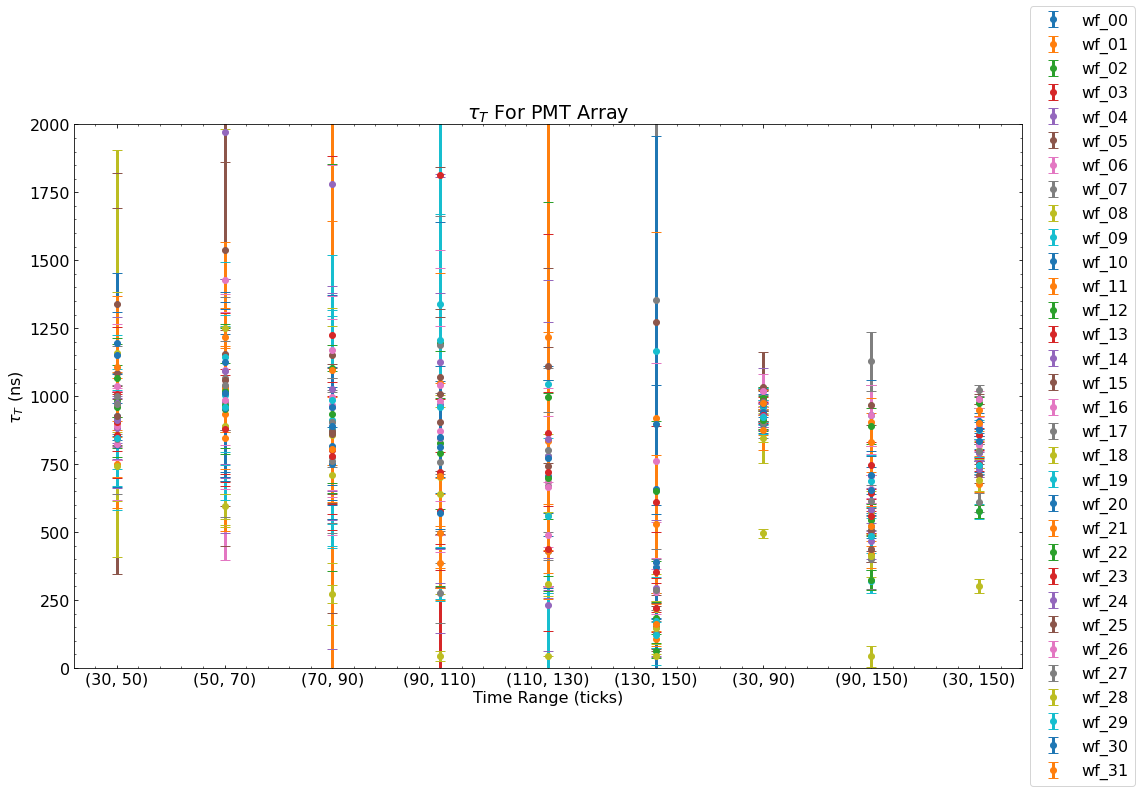

In [8]:
#  ++++--------------- Main -----------------++++

run_name = "run1"
fitranges = [(30,50), (50,70), (70,90), (90,110), (110,130), (130,150), (30,90), (90,150), (30,150)]
pars_li = []

#TODO: The response function being measured now is the deconvolved sum of wfs, consider adding the sum of deconvolved wfs option

fig, ax = plt.subplots(figsize =(17, 10))
for wfkeybyte in wffile_keys:
    wfkey = wfkeybyte.decode("utf-8")
    # Retrieving the stored data
    kaligned = np.loadtxt("data/"+run_name+"_output/kernel/"+run_name+wfkey+"Kernel.txt", dtype=float)
    snrf = np.loadtxt("data/"+run_name+"_output/kernel/"+run_name+wfkey+"SNR.txt", dtype=complex)
    res_fun = np.loadtxt("data/"+run_name+"_output/muon/"+run_name+wfkey+"resfun.txt", dtype=float)
    dc_res2 = wiener_deconvolution(res_fun, kaligned, 1/snrf)
    # Extract Latelight
    dc_res2_pars = np.zeros(3, dtype="object")
    for i in fitranges:
        # Fitting without constant
        #parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=resli[j][i[0]:i[1]]+abs(np.mean(resli[j][:10])), p0=(10, 96))
        yfunc = np.array([i for i in dc_res2[i[0]:i[1]]])
        parcache, covcache = optimize.curve_fit(f=expfun, xdata=np.linspace(i[0], i[1], i[1]-i[0]), ydata=yfunc, p0=(10, 96), sigma=np.abs(yfunc)**0.5)
        unccache = np.sqrt(np.diag(covcache))
        parnm = str(i[0])+"-"+str(i[1])
        dc_res2_pars = np.vstack((dc_res2_pars, [parnm, parcache, unccache]))
    pars_li.append(dc_res2_pars[1:])
    plt.errorbar([j for j in range(len(dc_res2_pars[1:]))], [dc_res2_pars[1:][:,1][j][0]*15.625 for j in range(len(dc_res2_pars[1:]))], yerr=[dc_res2_pars[1:][:,2][j][0]*15.625 for j in range(len(dc_res2_pars[1:]))], ls="None", label=wfkey, capsize=5., marker="o")

plt.xticks(np.arange(len(fitranges)), fitranges)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r"$\tau_T$ For PMT Array")
plt.xlabel("Time Range (ticks)")
plt.ylabel(r"$\tau_T$ (ns)")
plt.ylim(0,2000)
plt.show()

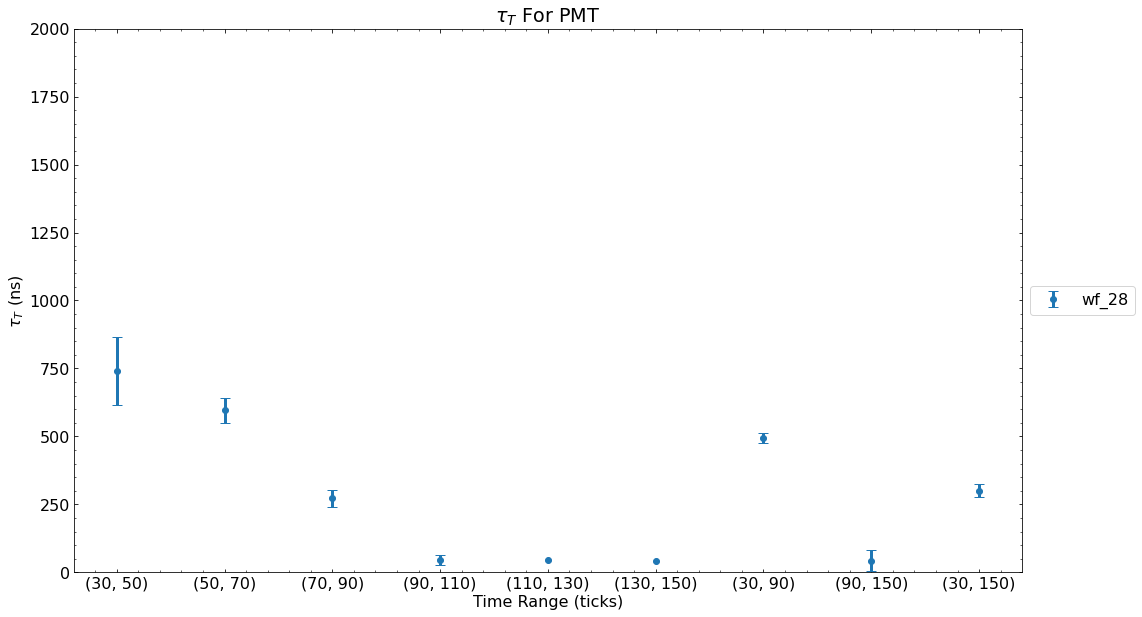

In [13]:
# Plotting result from a specific PMT

# PMT number to plot
n = 28

fig, ax = plt.subplots(figsize =(17, 10))
plt.errorbar([j for j in range(len(pars_li[n]))], [pars_li[n][:,1][j][0]*15.625 for j in range(len(pars_li[n]))], yerr=[pars_li[n][:,2][j][0]*15.625 for j in range(len(pars_li[n]))], ls="None", label="wf_"+str(n), capsize=5., marker="o")
plt.xticks(np.arange(len(fitranges)), fitranges)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r"$\tau_T$ For PMT")
plt.xlabel("Time Range (ticks)")
plt.ylabel(r"$\tau_T$ (ns)")
plt.ylim(0,2000)
plt.show()